<a href="https://colab.research.google.com/github/timnaruto/image_-Comparison-Siamese/blob/main/image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This project we are going to use triple loss effect to make sure our model knows similariry between two images. One will be positive, negative and then anchor image

In [1]:
## Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from tensorflow.keras.applications import ResNet50




### Load the dataset
* We are going to load the Totally Looks Like dataset and unzip it inside the ~/.keras directory in the local environment.
    - left.zip contains the images that we will use as the anchor.
    - right.zip contains the images that we will use as the positive sample (an image that looks like the anchor).

In [2]:
# Define cache directory (ensure it exists)
cache_dir = Path("./cache")
left_images_path = cache_dir / "left"
right_images_path = cache_dir / "right"

In [3]:

# Download and extract
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=748ad70e-483e-4e9d-b921-5cfc466ffc6b
To: /content/left.zip
100% 104M/104M [00:00<00:00, 137MB/s] 
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=8259434e-4902-4fa3-b739-24fc4fbe44dc
To: /content/right.zip
100% 104

## Preparing the data
* We are going to use a tf.data pipeline to load the data and generate the triplets that we need to train the Siamese network.

* We'll set up the pipeline using a zipped list with anchor, positive, and negative filenames as the source. The pipeline will load and preprocess the corresponding images.


## Data Pipeline
* Let's setup our data pipeline using a zipped list with an anchor, positive, and negative image filename as the source. The output of the pipeline contains the same triplet with every image loaded and preprocessed.

In [4]:
import os
import tensorflow as tf
from pathlib import Path



# Load and sort images (case-insensitive filtering)
left_images = sorted(
    [str(left_images_path / f) for f in os.listdir(left_images_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
)
right_images = sorted(
    [str(right_images_path / f) for f in os.listdir(right_images_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
)

# Ensure both sets have the same number of images
image_count = min(len(left_images), len(right_images))
left_images, right_images = left_images[:image_count], right_images[:image_count]

# Example labels: Assuming left & right images are similar (modify as needed)
labels = [1] * image_count  # 1 = similar, 0 = different (adjust if needed)

# Convert file paths and labels into TensorFlow datasets
left_dataset = tf.data.Dataset.from_tensor_slices(left_images)
right_dataset = tf.data.Dataset.from_tensor_slices(right_images)
labels_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))

# Combine image pairs with labels
dataset = tf.data.Dataset.zip((left_dataset, right_dataset, labels_dataset))

# Shuffle dataset before splitting
dataset = dataset.shuffle(buffer_size=image_count, seed=42)

# Define target image shape (ResNet50 input size)
TARGET_SHAPE = (224, 224)

def preprocess_image(filename):
    """
    Load and preprocess an image given its filename.
    """
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize [0,1]
    image = tf.image.resize(image, TARGET_SHAPE)  # Resize to match model input
    image = tf.keras.applications.resnet50.preprocess_input(image * 255.0)  # Apply ResNet50 preprocessing
    return image

def preprocess_image_pair(image1_filename, image2_filename, label):
    """
    Load and preprocess two images from their filenames with a label.
    """
    image1 = preprocess_image(image1_filename)
    image2 = preprocess_image(image2_filename)
    return (image1, image2), label

# Apply preprocessing
dataset = dataset.map(preprocess_image_pair, num_parallel_calls=tf.data.AUTOTUNE)

# Split dataset into training & validation sets (80/20 split)
train_size = int(image_count * 0.8)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Batch and prefetch datasets
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print(f"Training samples: {train_size}, Validation samples: {image_count - train_size}")


Training samples: 4812, Validation samples: 1204


## Displaying
* Let's take a look at a few examples of triplets. Notice how the first two images look alike while the third one is always different.

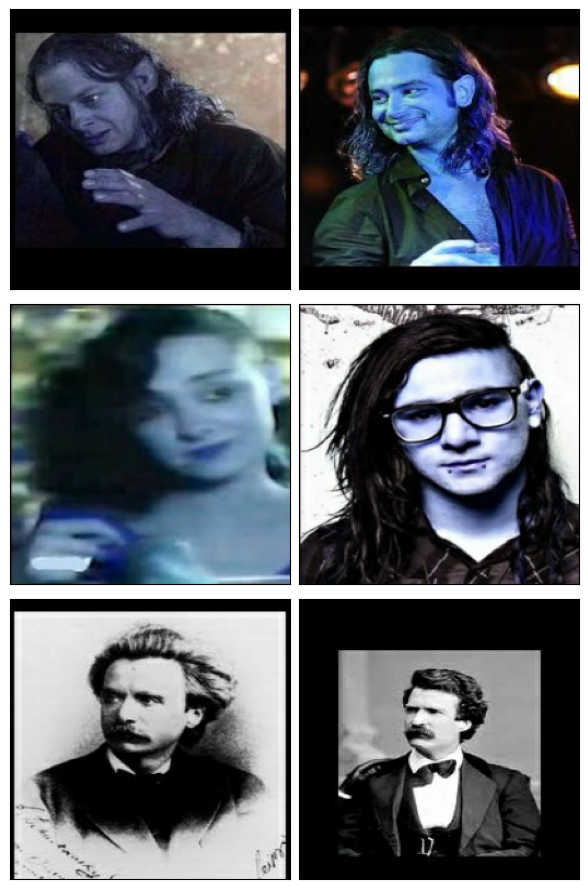

In [5]:
import matplotlib.pyplot as plt

def visualize(image1_batch, image2_batch):
    """
    Visualize a few image pairs from the supplied batch.

    Args:
        image1_batch: NumPy array of shape (batch_size, 224, 224, 3), first images.
        image2_batch: NumPy array of shape (batch_size, 224, 224, 3), second images.
    """
    def show(ax, image):
        # Rescale image from ResNet50 preprocessed range back to [0, 1] for visualization
        image = image.copy()  # Avoid modifying original data
        image = (image + [103.939, 116.779, 123.68]) / 255.0  # Undo ResNet50 preprocessing
        image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(6, 9))  # Adjusted figsize for 3 rows, 2 columns

    axs = fig.subplots(3, 2)  # 3 rows, 2 columns for image1 and image2
    for i in range(3):
        show(axs[i, 0], image1_batch[i])
        show(axs[i, 1], image2_batch[i])

    plt.tight_layout()
    plt.show()

# Extract one batch from train_dataset and visualize
batch = list(train_dataset.take(1).as_numpy_iterator())[0]
(image1_batch, image2_batch), labels_batch = batch  # Unpack the batch
visualize(image1_batch, image2_batch)

## Setting up the embedding generator model
Our Siamese Network will generate embeddings for each of the images of the triplet. To do this, we will use a ResNet50 model pretrained on ImageNet and connect a few Dense layers to it so we can learn to separate these embeddings.

We will freeze the weights of all the layers of the model up until the layer conv5_block1_out. This is important to avoid affecting the weights that the model has already learned. We are going to leave the bottom few layers trainable, so that we can fine-tune their weights during training.

In [6]:
# Load Pretrained ResNet50 (without the fully connected layer)
base_cnn = ResNet50(
    weights="imagenet", input_shape=TARGET_SHAPE + (3,), include_top=False
)

# Global Average Pooling instead of Flatten
gap = layers.GlobalAveragePooling2D()(base_cnn.output)

# Fully Connected Layers
dense1 = layers.Dense(512, activation="relu")(gap)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)

# L2 Normalized Embedding
output = layers.Dense(256, activation=None)(dense2)
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="L2_Norm")(output)

# Define Embedding Model
embedding = Model(base_cnn.input, output, name="Embedding")

# Freeze only the first few layers up to conv5_block1_out
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        break
    layer.trainable = False

# Define Inputs for two images
image1_input = layers.Input(name="image1", shape=TARGET_SHAPE + (3,))
image2_input = layers.Input(name="image2", shape=TARGET_SHAPE + (3,))

# Process Inputs with ResNet Preprocessing
image1_embedding = embedding(tf.keras.applications.resnet50.preprocess_input(image1_input))
image2_embedding = embedding(tf.keras.applications.resnet50.preprocess_input(image2_input))

## Setting up the Siamese Network model
The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

To compute the distance, we can use a custom layer DistanceLayer that returns both values as a tuple.

In [7]:
# Custom layer to compute cosine similarity
class CosineSimilarityLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, emb1, emb2):
        # Since embeddings are already L2-normalized, just compute dot product
        return tf.reduce_sum(emb1 * emb2, axis=-1)

# Compute cosine similarity
cosine_similarity = CosineSimilarityLayer()(image1_embedding, image2_embedding)

# Define Siamese Network
siamese_network = Model(
    inputs=[image1_input, image2_input],
    outputs=cosine_similarity
)

### Putting everything together
We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.

Let's create a Mean metric instance to track the loss of the training process.

In [8]:
class SiameseModel(Model):
    """
    Siamese Network Model using cosine similarity for two images.
    """
    def __init__(self, siamese_network, embedding, threshold=0.7):
        super().__init__()
        self.siamese_network = siamese_network
        self.embedding = embedding  # For standalone embedding predictions
        self.threshold = threshold
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        images, labels = data  # Expecting ([img1, img2], similarity_label)
        with tf.GradientTape() as tape:
            similarity = self.siamese_network(images)
            loss = self._compute_loss(similarity, labels)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        images, labels = data
        similarity = self.siamese_network(images)
        loss = self._compute_loss(similarity, labels)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, similarity, labels):
        # Binary cross-entropy loss, similarity ranges from -1 to 1
        loss = tf.keras.losses.binary_crossentropy(labels, (similarity + 1) / 2)  # Scale to [0, 1]
        return tf.reduce_mean(loss)

    @property
    def metrics(self):
        return [self.loss_tracker]

## Training


In [9]:
# Learning Rate Schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
siamese_model = SiameseModel(siamese_network, embedding)
siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")]
)

In [10]:
# Fit model with improved training strategy
history = siamese_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    steps_per_epoch=len(train_dataset) // 32,
    validation_steps=len(val_dataset) // 32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - loss: 0.1024 - val_loss: 0.0214
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 13s/step - loss: 0.0142 - val_loss: 0.0036
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 0.0025 - val_loss: 6.8891e-04
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 6.0181e-04 - val_loss: 3.2617e-04
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - loss: 2.3429e-04 - val_loss: 1.4770e-04
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - loss: 1.2630e-04 - val_loss: 7.0588e-05
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - loss: 7.5407e-05 - val_loss: 5.1504e-05
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 5.4618e-05 - val_loss: 4.1240e-05
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - loss: 4.1832e-05 - val_loss: 3.3521e-05
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 4.0339e-05 - val_loss: 2.7383e-05


In [37]:
def predict_similarity(image_path1, image_path2, model):
    """
    Predict similarity using the full Siamese network.

    Args:
        image_path1 (str): Path to the first image file.
        image_path2 (str): Path to the second image file.
        model: SiameseModel instance.

    Returns:
        float: Similarity score predicted by the Siamese network.
    """
    image1 = preprocess_image(image_path1)
    image2 = preprocess_image(image_path2)

    image1_processed = tf.expand_dims(image1, 0)
    image2_processed = tf.expand_dims(image2, 0)

    similarity = siamese_model.predict([image1_processed, image2_processed])[0]
    print(f"Network-based Cosine Similarity: {similarity}")
    return similarity

In [38]:
image1_path = "/content/03526.jpg"
image2_path = "/content/05766.jpg"
similarit = predict_similarity(image1_path, image2_path, siamese_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Network-based Cosine Similarity: 0.9999620318412781


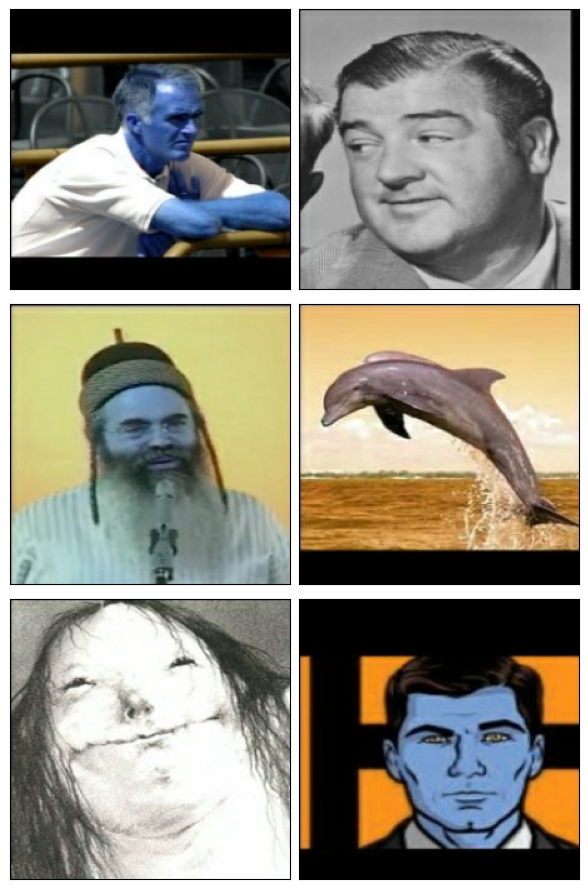

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Manual Cosine Similarity (Embeddings): 0.9999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Network Predicted Cosine Similarity: 0.9999
Ground Truth Label: 0


In [40]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming train_dataset is defined as in the two-image pipeline
# It yields ((image1_batch, image2_batch), labels_batch)

# Visualization function (from previous response)
def visualize(image1_batch, image2_batch):
    """
    Visualize a few image pairs from the supplied batch.
    """
    def show(ax, image):
        image = (image + [103.939, 116.779, 123.68]) / 255.0  # Undo ResNet50 preprocessing
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(6, 9))
    axs = fig.subplots(3, 2)
    for i in range(min(3, len(image1_batch))):
        show(axs[i, 0], image1_batch[i])
        show(axs[i, 1], image2_batch[i])

    plt.tight_layout()
    plt.show()

# Get a sample batch from train_dataset
sample = next(iter(val_dataset))  # ((image1_batch, image2_batch), labels_batch)
(image1_batch, image2_batch), labels_batch = sample

# Visualize the first batch
visualize(image1_batch, image2_batch)

# Extract the first pair from the batch for prediction
image1 = image1_batch[0]  # Shape: (224, 224, 3)
image2 = image2_batch[0]  # Shape: (224, 224, 3)

# Compute embeddings using the embedding model
embedding = siamese_model.embedding  # From your SiameseModel instance
image1_embedding = embedding.predict(tf.expand_dims(image1, axis=0))  # Shape: (1, 256)
image2_embedding = embedding.predict(tf.expand_dims(image2, axis=0))  # Shape: (1, 256)

# Compute cosine similarity manually
cosine_similarity = np.dot(image1_embedding, image2_embedding.T)[0][0]
print(f"Manual Cosine Similarity (Embeddings): {cosine_similarity:.4f}")

# Predict similarity using the full Siamese network
similarity = siamese_model.predict([tf.expand_dims(image1, 0), tf.expand_dims(image2, 0)])[0]
print(f"Network Predicted Cosine Similarity: {similarity:.4f}")

# Compare with the ground truth label (if applicable)
print(f"Ground Truth Label: {labels_batch[0]:.0f}")

In [42]:
# Rebuild dataset with both similar and dissimilar pairs
left_images = sorted([str(f) for f in Path("cache/left").glob("*.[jp][pn]g")])
right_images = sorted([str(f) for f in Path("cache/right").glob("*.[jp][pn]g")])
image_count = min(len(left_images), len(right_images))
left_images = left_images[:image_count]
right_images = right_images[:image_count]

# Create similar and dissimilar pairs
similar_pairs = list(zip(left_images, right_images))  # Assuming these are similar
dissimilar_pairs = list(zip(left_images, right_images[1:] + [right_images[0]]))  # Shifted for dissimilarity

# Combine pairs and labels
all_image1_files = [p[0] for p in similar_pairs] + [p[0] for p in dissimilar_pairs]
all_image2_files = [p[1] for p in similar_pairs] + [p[1] for p in dissimilar_pairs]
labels = [1] * image_count + [0] * image_count
image_count *= 2

# Create dataset
image1_dataset = tf.data.Dataset.from_tensor_slices(all_image1_files)
image2_dataset = tf.data.Dataset.from_tensor_slices(all_image2_files)
labels_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
dataset = tf.data.Dataset.zip((image1_dataset, image2_dataset, labels_dataset))
dataset = dataset.shuffle(buffer_size=1024, seed=42)

# Preprocessing
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet50.preprocess_input(image * 255.0)
    return image

def preprocess_image_pair(image1_filename, image2_filename, label):
    image1 = preprocess_image(image1_filename)
    image2 = preprocess_image(image2_filename)
    return (image1, image2), label

dataset = dataset.map(preprocess_image_pair, num_parallel_calls=tf.data.AUTOTUNE)

# Split into training and validation
train_size = round(image_count * 0.8)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

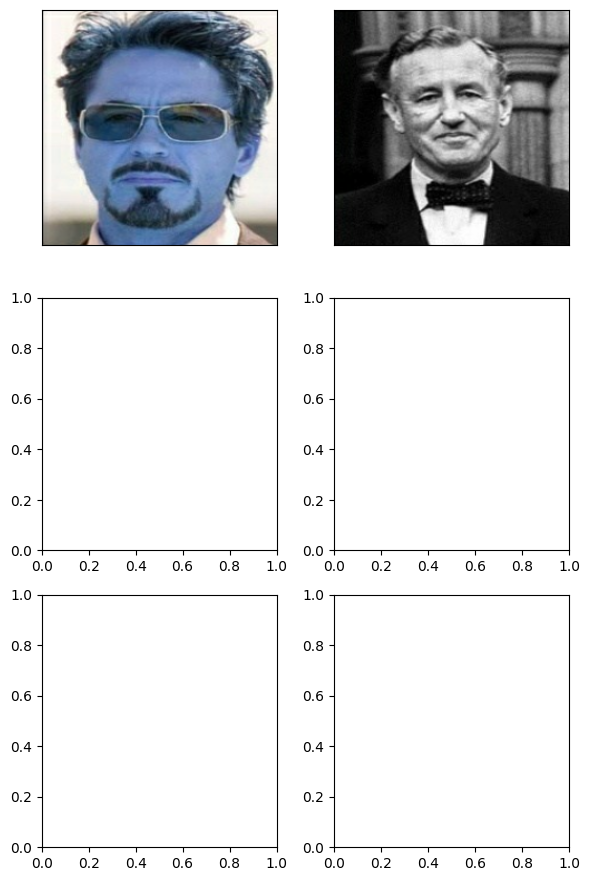

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Manual Cosine Similarity (Embeddings): 0.9999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Network Predicted Cosine Similarity: 0.9999
Ground Truth Label: 0


In [43]:
# Find a dissimilar pair
for batch in val_dataset:
    (image1_batch, image2_batch), labels_batch = batch
    for i in range(len(labels_batch)):
        if labels_batch[i] == 0:  # Dissimilar pair
            image1 = image1_batch[i]
            image2 = image2_batch[i]
            label = labels_batch[i]
            break
    else:
        continue
    break

# Visualize the dissimilar pair
visualize(np.expand_dims(image1, 0), np.expand_dims(image2, 0))

# Compute embeddings and predict
image1_embedding = siamese_model.embedding.predict(tf.expand_dims(image1, 0))
image2_embedding = siamese_model.embedding.predict(tf.expand_dims(image2, 0))
cosine_similarity = np.dot(image1_embedding, image2_embedding.T)[0][0]
print(f"Manual Cosine Similarity (Embeddings): {cosine_similarity:.4f}")

similarity = siamese_model.predict([tf.expand_dims(image1, 0), tf.expand_dims(image2, 0)])[0]
print(f"Network Predicted Cosine Similarity: {similarity:.4f}")

print(f"Ground Truth Label: {label:.0f}")

In [16]:
!tensorflowjs_converter --input_format keras image_similarity.h5 tfjs_model

2025-03-24 17:34:40.116025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742837680.151855   51684 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742837680.163091   51684 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742837680.190004   51684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742837680.190040   51684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742837680.190049   51684 computation_placer.cc:177] computation placer alr